In [1]:
import numpy as np
import matplotlib.pyplot as matplot
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import rand_score
from utils import *

In [2]:
# importing the dataset
X,y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)
    
# deleting the columns with unique values and rescaling
# X = X[:, ~np.all(X[1:] == X[:-1], axis=0)]
X = X/255
scaler = StandardScaler()
X = scaler.fit_transform(X)

# check if mean = 0 and std = 1
print((X.mean(axis = 0)).mean())
print((X.std(axis = 0)).mean())

8.644688463608271e-19
0.9170918367346939


In [3]:
# splitting the data into train, validation and test
X_old, X_new, y_old, y_new = train_test_split(X, y, test_size = 0.5, random_state = 0)
X_train_80, X_test, y_train_80, y_test = train_test_split(X_new, y_new, test_size = 0.2, random_state = 0)
X_train, X_valid , y_train, y_valid = train_test_split(X_train_80, y_train_80, test_size = 0.25, random_state = 0)

In [4]:
print("original dataset: ", X.shape, y.shape)
print("reduced dataset: ", X_new.shape, y_new.shape)
print("train set: ", X_train.shape, y_train.shape)
print("validation set: ", X_valid.shape, y_valid.shape)
print("test set: ", X_test.shape, y_test.shape)

original dataset:  (70000, 784) (70000,)
reduced dataset:  (35000, 784) (35000,)
train set:  (21000, 784) (21000,)
validation set:  (7000, 784) (7000,)
test set:  (7000, 784) (7000,)


Visualization of PCA transformation with 2 components.

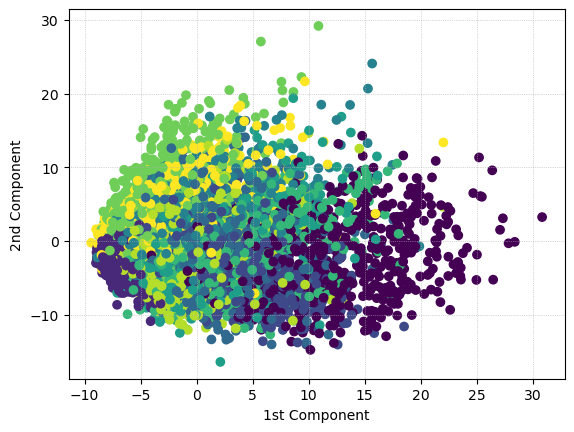

In [5]:
pca = PCA(n_components=2)
X_valid_proj = pca.fit_transform(X_valid)

fig, ax = plt.subplots()
ax.scatter(X_valid_proj[:,0],X_valid_proj[:,1], c=y_valid)

ax.set_xlabel("1st Component")
ax.set_ylabel("2nd Component")
ax.grid(linestyle=':', linewidth=.5)

In [6]:
half_train_time = []
half_test_time = []
half_rand = []
entire_train_time = []
entire_test_time = []
entire_rand = []
double_train_time = []
double_test_time = []
double_rand = []

for n_comp in [2, 10, 50, 100, 150, 200]: 
    pca = PCA(n_components=n_comp)
    X_train_proj = pca.fit_transform(X_train)
    X_valid_proj = pca.fit_transform(X_valid)
    
    print('Projected train and validation sets : ',X_train_proj.shape, X_valid_proj.shape)
    
    bd = estimate_bandwidth(X_train_proj, n_jobs = -1)
    
    for band in [bd/2, bd, bd*2]:
        ms = MeanShift(bandwidth=band, n_jobs = -1)
        
        start_train = time.time()
        ms.fit(X_train_proj)
        time_train = time.time() - start_train
        
        start_test = time.time()
        labels = ms.predict(X_valid_proj)
        time_test = time.time() - start_test
        
        cluster_centers = ms.cluster_centers_
        labels_unique = np.unique(labels)
        n_clusters_ = len(labels_unique)
        
        rand = rand_score(y_valid, labels)
        # rand = rand_index(y_valid, labels)
        
        print(f'n_comp : {n_comp} --- bandwidth : {band} --- n_clusters : {n_clusters_} --- rand index : {rand}')
        print('Train time : ', time_train)
        print('Test_time : ', time_test)
        
        if band == bd/2:
            half_train_time.append(time_train)
            half_test_time.append(time_test)
            half_rand.append(rand)
        else:
            if band == bd:
                entire_train_time.append(time_train)
                entire_test_time.append(time_test)
                entire_rand.append(rand)
            else:
                double_train_time.append(time_train)
                double_test_time.append(time_test)
                double_rand.append(rand)

Projected train and validation sets :  (21000, 2) (7000, 2)
n_comp : 2 --- bandwidth : 3.607878982519357 --- n_clusters : 5 --- rand index : 0.2526287020594779
Train time :  29.817272186279297
Test_time :  0.0035767555236816406
n_comp : 2 --- bandwidth : 7.215757965038714 --- n_clusters : 1 --- rand index : 0.10041312024166718
Train time :  15.886313915252686
Test_time :  0.0003809928894042969
n_comp : 2 --- bandwidth : 14.431515930077428 --- n_clusters : 1 --- rand index : 0.10041312024166718
Train time :  9.157043218612671
Test_time :  0.00037670135498046875
Projected train and validation sets :  (21000, 10) (7000, 10)
n_comp : 10 --- bandwidth : 8.171880408599856 --- n_clusters : 90 --- rand index : 0.6959348070132468
Train time :  43.934364795684814
Test_time :  0.01162099838256836
n_comp : 10 --- bandwidth : 16.343760817199712 --- n_clusters : 3 --- rand index : 0.10201208335884718
Train time :  21.94683599472046
Test_time :  0.0008590221405029297
n_comp : 10 --- bandwidth : 32.68

KeyboardInterrupt: 

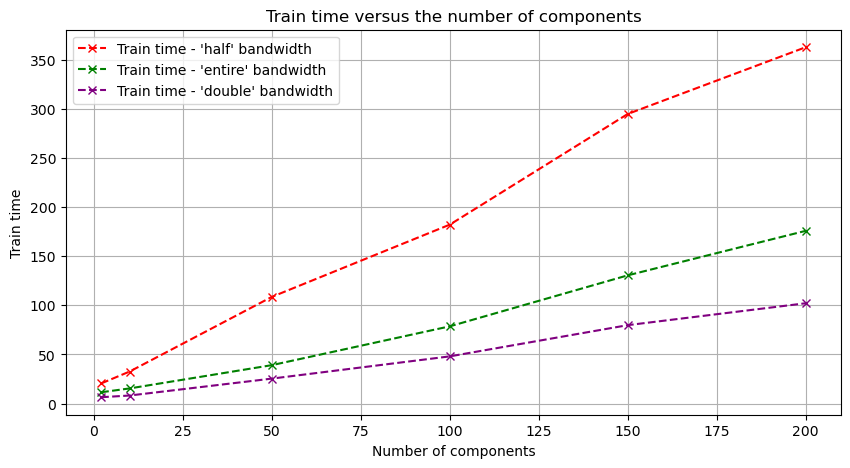

In [14]:
n_comp = [2, 10, 50, 100, 150, 200]

matplot.subplots(figsize=(10, 5))
matplot.plot(n_comp, half_train_time,'--x' ,color='red' , label="Train time - 'half' bandwidth")
matplot.plot(n_comp, entire_train_time,'--x' , color = 'green', label="Train time - 'entire' bandwidth")
matplot.plot(n_comp, double_train_time,'--x' , color = 'purple', label="Train time - 'double' bandwidth")
matplot.grid(True)
matplot.xlabel("Number of components")
matplot.ylabel("Train time (s)")
matplot.legend()
matplot.title('Train time vs the number of components')
matplot.show()

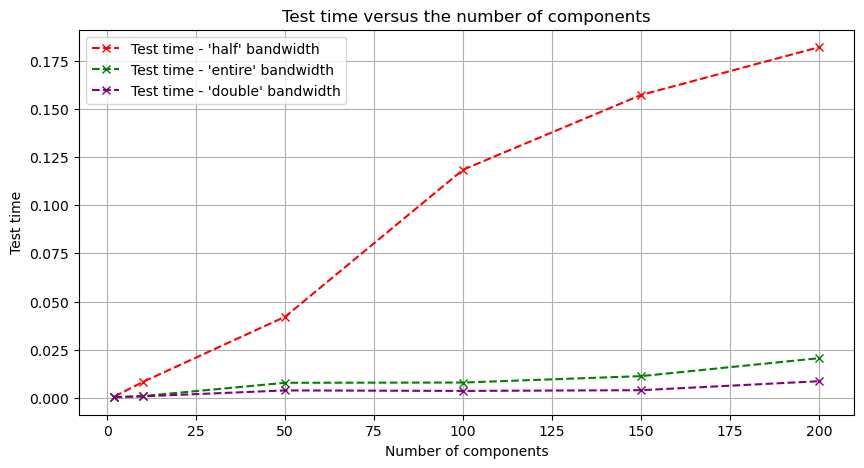

In [15]:
n_comp = [2, 10, 50, 100, 150, 200]

matplot.subplots(figsize=(10, 5))
matplot.plot(n_comp, half_test_time,'--x' ,color='red' , label="Test time - 'half' bandwidth")
matplot.plot(n_comp, entire_test_time,'--x' , color = 'green', label="Test time - 'entire' bandwidth")
matplot.plot(n_comp, double_test_time,'--x' , color = 'purple', label="Test time - 'double' bandwidth")
matplot.grid(True)
matplot.xlabel("Number of components")
matplot.ylabel("Test time (s)")
matplot.legend()
matplot.title('Test time vs the number of components')
matplot.show()

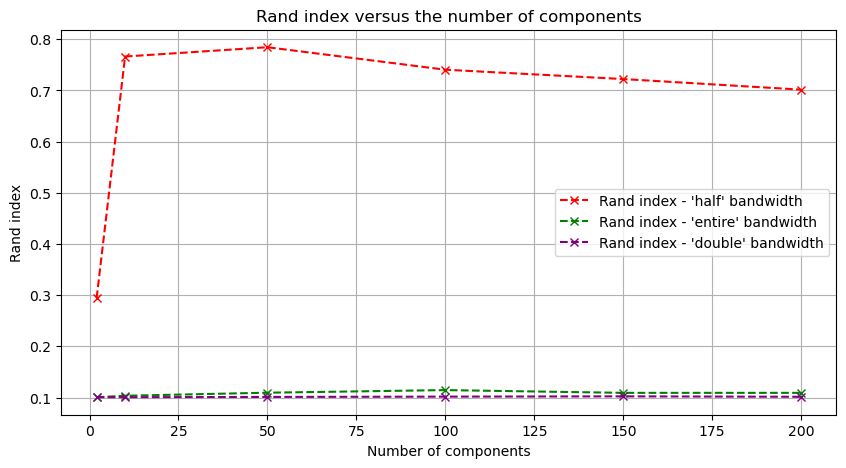

In [17]:
n_comp = [2, 10, 50, 100, 150, 200]

matplot.subplots(figsize=(10, 5))
matplot.plot(n_comp, half_rand,'--x' ,color='red' , label="Rand index - 'half' bandwidth")
matplot.plot(n_comp, entire_rand,'--x' , color = 'green', label="Rand index - 'entire' bandwidth")
matplot.plot(n_comp, double_rand,'--x' , color = 'purple', label="Rand index - 'double' bandwidth")
matplot.grid(True)
matplot.xlabel("Number of components")
matplot.ylabel("Rand index")
matplot.legend()
matplot.title('Rand index vs the number of components')
matplot.show()

Visualization of the clustering results for n_comp = 2 and bandwidth = 3.6059846993853433

In [18]:
pca = PCA(n_components=2)
X_train_proj = pca.fit_transform(X_train)
X_test_proj = pca.fit_transform(X_test)

ms = MeanShift(bandwidth=3.6059846993853433, n_jobs = -1)

start_train = time.time()
ms.fit(X_train_proj)
time_train = time.time() - start_train

start_test = time.time()
labels = ms.predict(X_test_proj)
time_test = time.time() - start_test

cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
rand = rand_index(y_test, labels)

print(f'bandwidth : 3.6059846993853433 --- n_clusters : {n_clusters_} --- rand index : {rand}')
print('Train time : ', time_train)
print('Test_time : ', time_test)

KeyError: 0

In [8]:
plot_clustering(X_test, labels, None)

NameError: name 'plot_clustering' is not defined

In [ ]:
matplot.figure(1)
matplot.clf()

# da vedere risultato della cella precedente
colors = ["#dede00", "#377eb8", "#f781bf"]
markers = ["x", "o", "^"]

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], markers[k], color=col)
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        markers[k],
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Number of clusters: %d" % n_clusters_)
plt.show()